# Pix2Pix Image-to-Image Translation on Google Colab with T4 GPU

In [ ]:
# --- SETUP ---
!pip install -q tensorflow matplotlib numpy pillow tqdm

In [ ]:
from google.colab import files
import zipfile
import os

# Define the target directory
DATA_DIR = '/content/data/train/'

# Create the directory if it doesn't exist
os.makedirs(DATA_DIR, exist_ok=True)

# Upload the dataset (e.g., a zip file)
uploaded = files.upload()  # This will prompt file selection

# Unzip if it's a zip file, or move the file directly
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)
            print(f"Extracted {filename} to {DATA_DIR}")
    else:
        # Move the file to the DATA_DIR
        os.rename(filename, os.path.join(DATA_DIR, filename))
        print(f"Moved {filename} to {DATA_DIR}")


Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
Saving 9.jpg to 9.jpg
Saving 10.jpg to 10.jpg
Saving 11.jpg to 11.jpg
Saving 12.jpg to 12.jpg
Saving 13.jpg to 13.jpg
Saving 14.jpg to 14.jpg
Saving 15.jpg to 15.jpg
Saving 16.jpg to 16.jpg
Saving 17.jpg to 17.jpg
Saving 18.jpg to 18.jpg
Saving 19.jpg to 19.jpg
Saving 20.jpg to 20.jpg
Saving 21.jpg to 21.jpg
Saving 22.jpg to 22.jpg
Saving 23.jpg to 23.jpg
Saving 24.jpg to 24.jpg
Saving 25.jpg to 25.jpg
Saving 26.jpg to 26.jpg
Saving 27.jpg to 27.jpg
Saving 28.jpg to 28.jpg
Saving 29.jpg to 29.jpg
Saving 30.jpg to 30.jpg
Saving 31.jpg to 31.jpg
Saving 32.jpg to 32.jpg
Saving 33.jpg to 33.jpg
Saving 34.jpg to 34.jpg
Saving 35.jpg to 35.jpg
Saving 36.jpg to 36.jpg
Saving 37.jpg to 37.jpg
Saving 38.jpg to 38.jpg
Saving 39.jpg to 39.jpg
Saving 40.jpg to 40.jpg
Saving 41.jpg to 41.jpg
Saving 42.jpg to 42.jpg
Saving 43.

In [ ]:
from google.colab import files
import zipfile
import os

# Define the target directory
DATA_DIR = '/content/data/test/'

# Create the directory if it doesn't exist
os.makedirs(DATA_DIR, exist_ok=True)

# Upload the dataset (e.g., a zip file)
uploaded = files.upload()  # This will prompt file selection

# Unzip if it's a zip file, or move the file directly
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)
            print(f"Extracted {filename} to {DATA_DIR}")
    else:
        # Move the file to the DATA_DIR
        os.rename(filename, os.path.join(DATA_DIR, filename))
        print(f"Moved {filename} to {DATA_DIR}")


Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
Saving 9.jpg to 9.jpg
Saving 10.jpg to 10.jpg
Saving 11.jpg to 11.jpg
Saving 12.jpg to 12.jpg
Saving 13.jpg to 13.jpg
Saving 14.jpg to 14.jpg
Saving 15.jpg to 15.jpg
Saving 16.jpg to 16.jpg
Saving 17.jpg to 17.jpg
Saving 18.jpg to 18.jpg
Saving 19.jpg to 19.jpg
Saving 20.jpg to 20.jpg
Saving 21.jpg to 21.jpg
Saving 22.jpg to 22.jpg
Saving 23.jpg to 23.jpg
Saving 24.jpg to 24.jpg
Saving 25.jpg to 25.jpg
Saving 26.jpg to 26.jpg
Saving 27.jpg to 27.jpg
Saving 28.jpg to 28.jpg
Saving 29.jpg to 29.jpg
Saving 30.jpg to 30.jpg
Saving 31.jpg to 31.jpg
Saving 32.jpg to 32.jpg
Saving 33.jpg to 33.jpg
Saving 34.jpg to 34.jpg
Saving 35.jpg to 35.jpg
Saving 36.jpg to 36.jpg
Saving 37.jpg to 37.jpg
Saving 38.jpg to 38.jpg
Saving 39.jpg to 39.jpg
Saving 40.jpg to 40.jpg
Saving 41.jpg to 41.jpg
Saving 42.jpg to 42.jpg
Saving 43.

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from google.colab import files

from tensorflow.keras.layers import (Conv2D, BatchNormalization, LeakyReLU,
                                     Conv2DTranspose, ReLU, Dropout, Concatenate, Input, ZeroPadding2D)
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import *



In [ ]:
# --- GENERATOR ---
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                     kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU(alpha=0.2))
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

def build_generator():
    inputs = Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same',
                          kernel_initializer=initializer, activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    x = last(x)
    return Model(inputs=inputs, outputs=x)

In [ ]:
# --- DISCRIMINATOR ---
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = Input(shape=[256, 256, 3], name='input_image')
    tar = Input(shape=[256, 256, 3], name='target_image')
    x = Concatenate()([inp, tar])
    down1 = Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    down1 = LeakyReLU(alpha=0.2)(down1)
    down2 = Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(down1)
    down2 = BatchNormalization()(down2)
    down2 = LeakyReLU(alpha=0.2)(down2)
    down3 = Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(down2)
    down3 = BatchNormalization()(down3)
    down3 = LeakyReLU(alpha=0.2)(down3)
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm = BatchNormalization()(conv)
    leaky_relu = LeakyReLU(alpha=0.2)(batchnorm)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return Model(inputs=[inp, tar], outputs=last)

In [ ]:
# --- DATA LOADING ---
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1] // 2
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width])
    real_image = tf.image.resize(real_image, [height, width])
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3])
    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

def load_dataset(data_dir, batch_size=1, is_train=True):
    dataset = tf.data.Dataset.list_files(data_dir + '/*.jpg')
    dataset = dataset.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    if is_train:
        dataset = dataset.map(lambda x, y: resize(x, y, 286, 286))
        dataset = dataset.map(random_crop)
        dataset = dataset.map(normalize)
        dataset = dataset.shuffle(400)
    else:
        dataset = dataset.map(lambda x, y: resize(x, y, 256, 256))
        dataset = dataset.map(normalize)
    return dataset.batch(batch_size)

In [ ]:
# --- TRAINING ---
LAMBDA = 100
EPOCHS = 10
BATCH_SIZE = 1
DATA_DIR = '/content/data/train'  # Upload your dataset to this path
loss_object = BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_fake_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_fake_output), disc_fake_output)
    return real_loss + fake_loss

def generator_loss(disc_fake_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_fake_output), disc_fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (LAMBDA * l1_loss)

In [ ]:
# Build models
generator = build_generator()
discriminator = build_discriminator()
generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

def generate_images(model, input_image, target):
    prediction = model(input_image, training=True)
    plt.figure(figsize=(15, 5))
    display_list = [input_image[0], target[0], prediction[0]]
    title = ['Input', 'Ground Truth', 'Prediction']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5 + 0.5))
        plt.axis('off')
    plt.show()

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_fake_output = discriminator([input_image, gen_output], training=True)
        gen_loss = generator_loss(disc_fake_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_fake_output)
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10


100%|██████████| 400/400 [01:01<00:00,  6.53it/s]


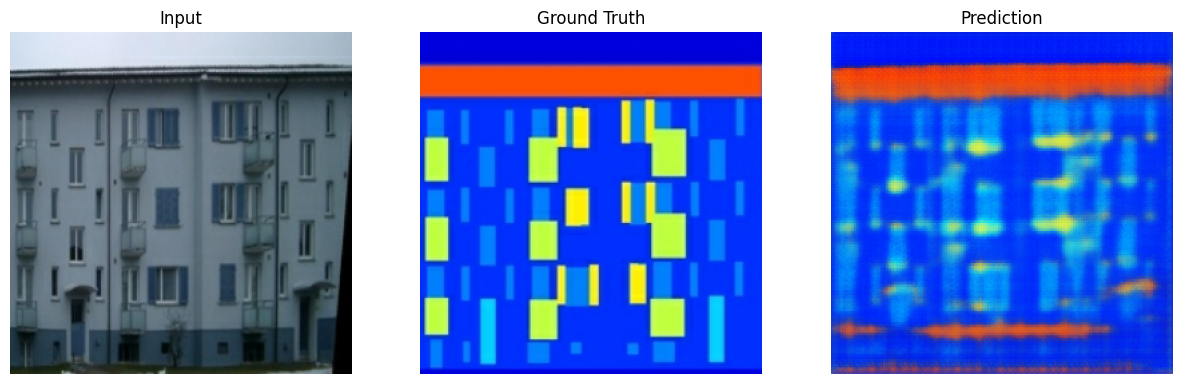

Epoch 2/10


100%|██████████| 400/400 [00:45<00:00,  8.86it/s]


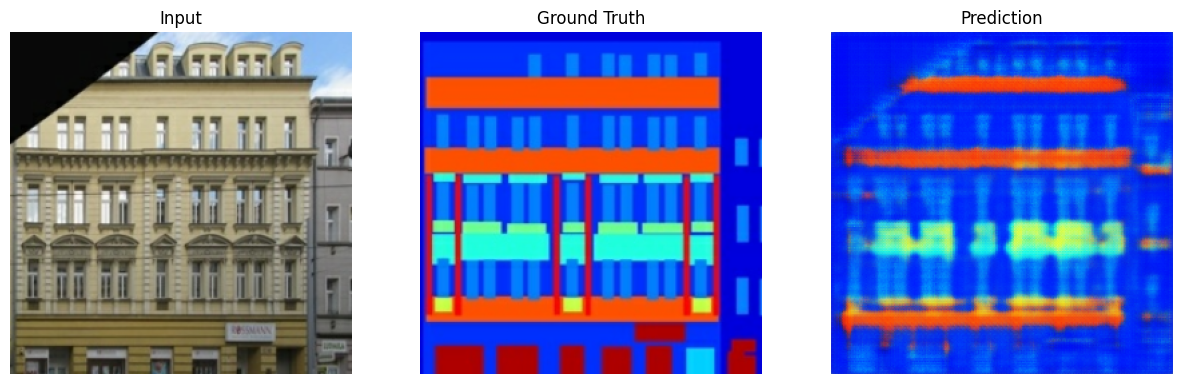

Epoch 3/10


100%|██████████| 400/400 [00:44<00:00,  8.95it/s]


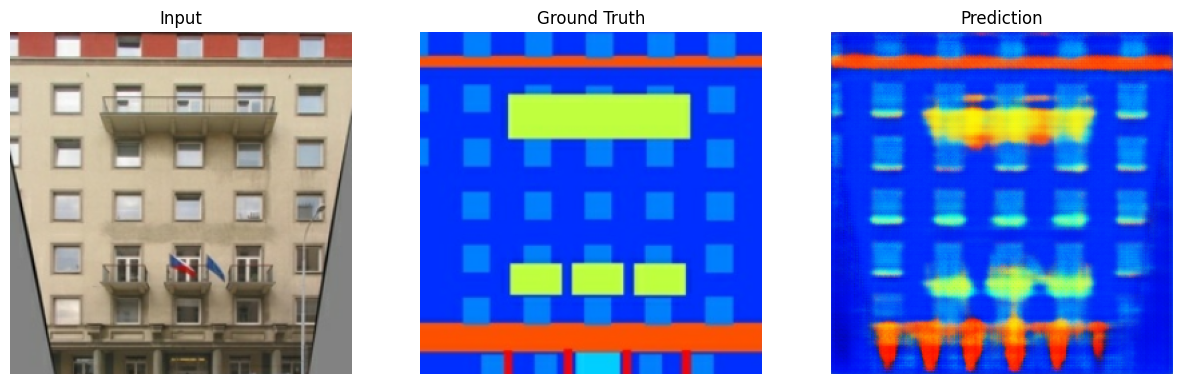

Epoch 4/10


100%|██████████| 400/400 [00:44<00:00,  8.99it/s]


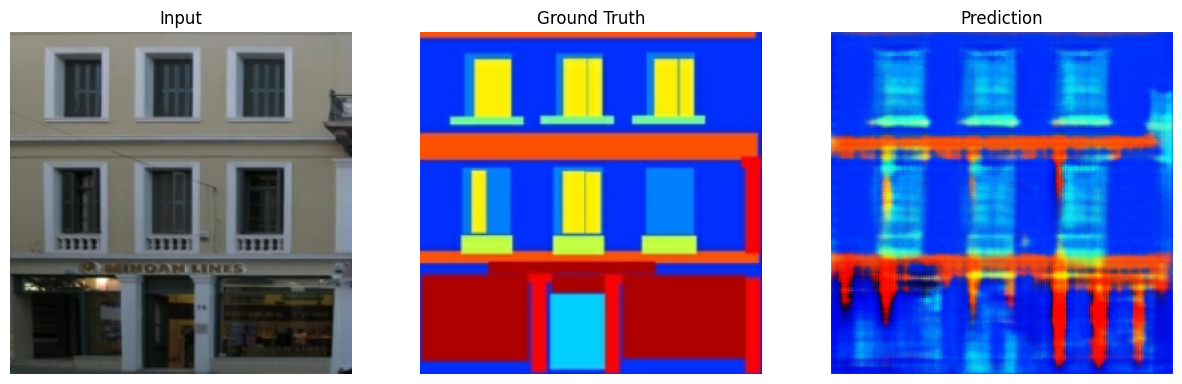

Epoch 5/10


100%|██████████| 400/400 [00:44<00:00,  8.89it/s]


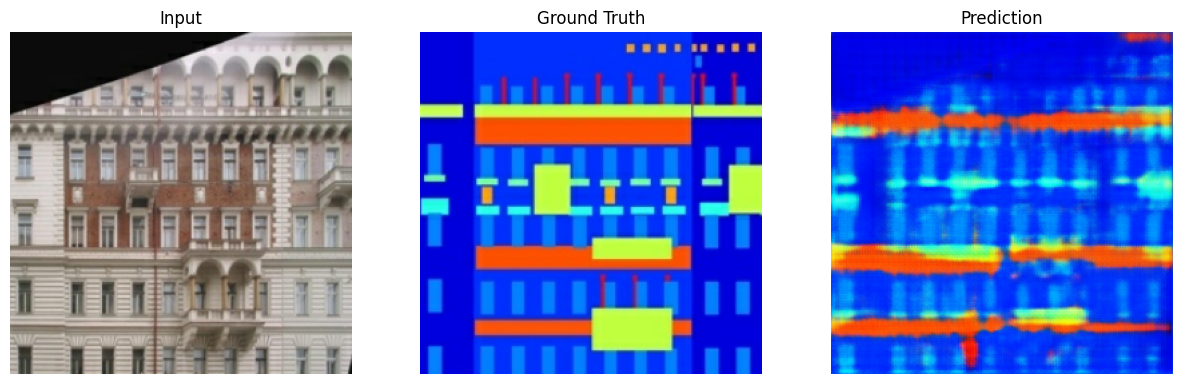

Epoch 6/10


100%|██████████| 400/400 [01:21<00:00,  4.88it/s]


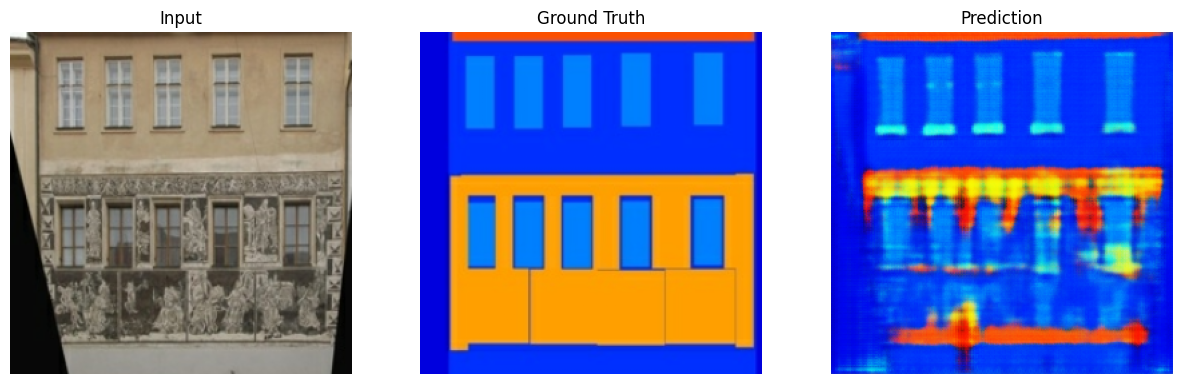

Epoch 7/10


100%|██████████| 400/400 [00:44<00:00,  8.89it/s]


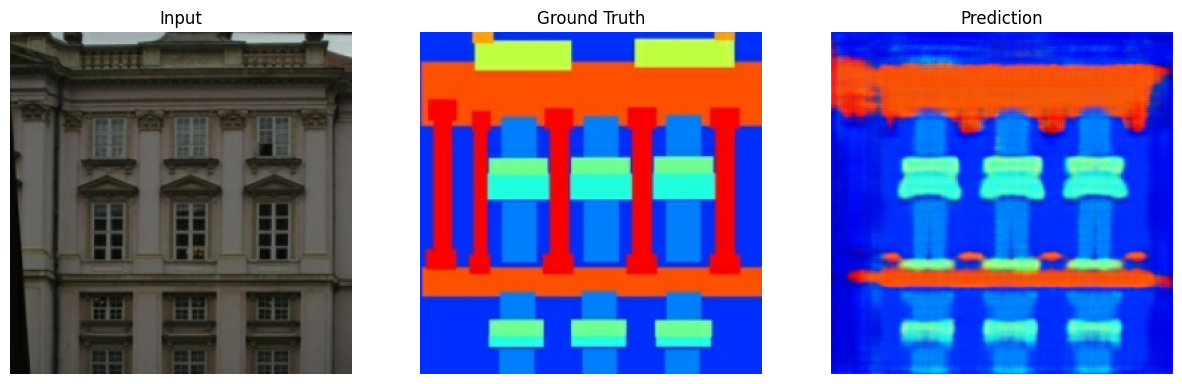

Epoch 8/10


100%|██████████| 400/400 [01:21<00:00,  4.88it/s]


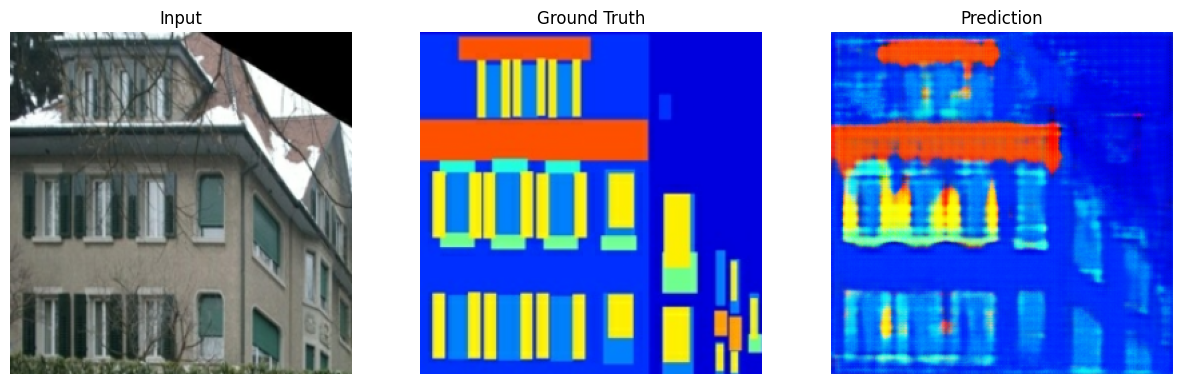

Epoch 9/10


100%|██████████| 400/400 [00:45<00:00,  8.88it/s]


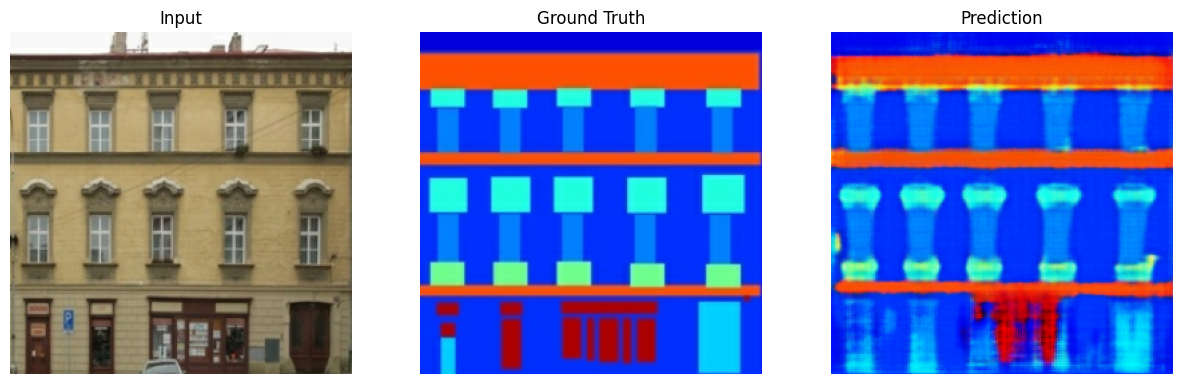

Epoch 10/10


100%|██████████| 400/400 [00:44<00:00,  8.97it/s]


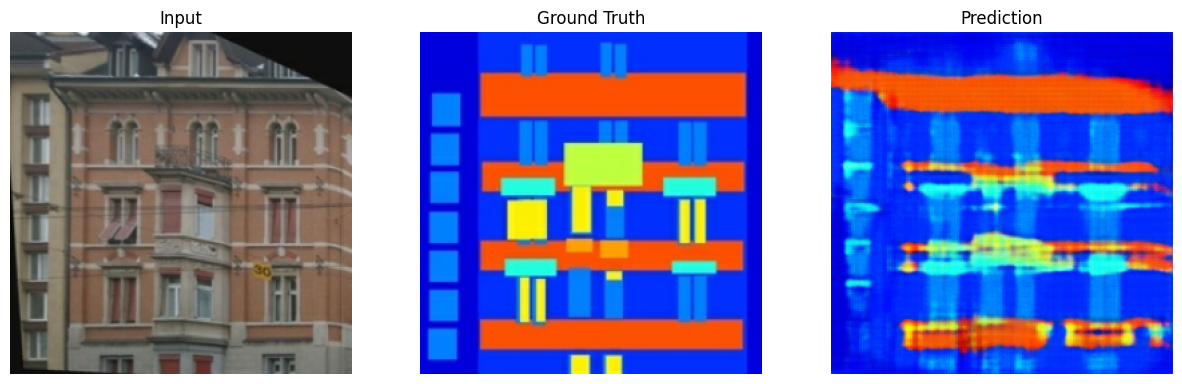

Training completed. You can now test your model.


In [ ]:
# Training loop
train_dataset = load_dataset(DATA_DIR, BATCH_SIZE, is_train=True)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for input_image, target in tqdm(train_dataset):
        train_step(input_image, target)
    generate_images(generator, input_image, target)

print("Training completed. You can now test your model.")

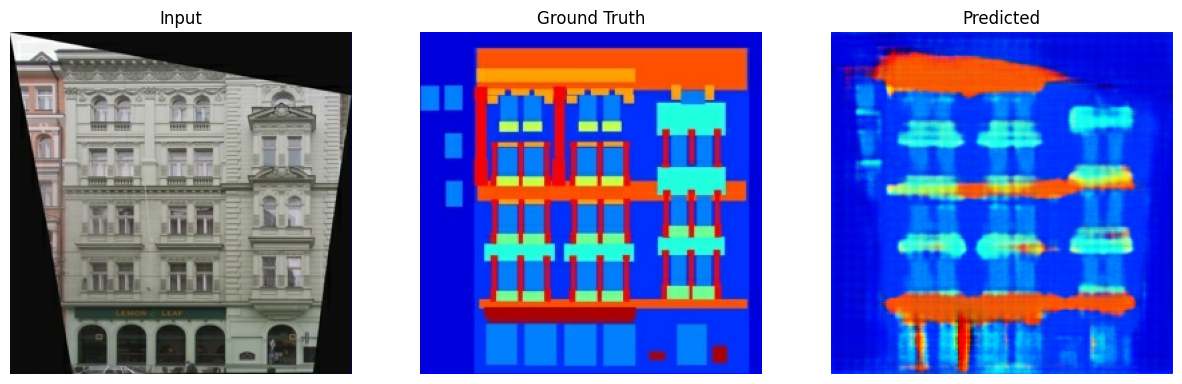

In [ ]:
def generate_images(model, test_input, target):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 5))
    display_list = [test_input[0], target[0], prediction[0]]
    titles = ['Input', 'Ground Truth', 'Predicted']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

# Run on one test image
test_dataset = load_dataset('data/test', batch_size=1, is_train=False)
for inp, tar in test_dataset.take(1):
    generate_images(generator, inp, tar)


In [ ]:
generator.save("pix2pix_generator_model.h5")

NameError: name 'generator' is not defined

In [ ]:
#save to desktop

import os

# Path to your desktop (works on Windows)
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

# File name for saved weights
weights_file = os.path.join(desktop_path, "generator_weights.h5")

# Save the weights
generator.save_weights(weights_file)

print(f"✅ Generator weights saved to: {weights_file}")


In [ ]:
from tensorflow.keras.models import load_model
generator = load_model("pix2pix_generator.h5", compile=False)
